# Import

In [1]:
#Requires ASE, scikitlearn, numpy


#These next imports are needed to set up the structure:
import pandas as pd
from ase.io import read
import numpy as np
from ase.visualize import view
import copy
import matplotlib.pyplot as plt

#import surfEP
import sys
sys.path.append("../algorithms")
from Lv_surfEP import surfEP

# Example 1: A single adsorption energy prediction

In [2]:
### Input
hostMetal = 'Sc'
dopingMetal = 'Pt'
adsorbate = 'H'
dopingLocations = [0,1,2,4,12]
siteType = 'Top'#"FCCHollow"
adsorptionSiteIndices = [[1,3,4]] 
surfaceIndicesList = [[0,1,2,3,4,5,6,7,8]]

In [3]:
### Set up and view structure
# Import host metal structure
slab = read('../data/HostStructures/POSCAR_'+hostMetal)
# Dope in metal
symbols = np.array(slab.get_chemical_symbols())
symbols[dopingLocations] = dopingMetal
slab.set_chemical_symbols(symbols)

### Note: these next lines are not needed to make the prediction; they just help visualize the surface and site.
view(slab)

In [4]:
### Predict adsorption energy
adsPredictor = surfEP(verbose=False,jsonDirectory ='../data/JSONFiles_Lv/',elementDataDirectory='../data/')
predAdsList = adsPredictor.atomsToAds([slab] ,[adsorbate],siteType,[adsorptionSiteIndices], surfaceIndicesList)
print('Predicted adsorption energy:', predAdsList[0][0][0])


Predicted adsorption energy: -0.4748122594828601


# Example 2: A set of adsorption energy predictions
- Choose a host metal, doping locations, and two hollow sites. Loop over all dopants.
- Output: outermost index is over surfaces, next index is over adsorbates, innermost index is over sites.

In [5]:
### Input
hostMetal = 'Ag' # can be any of: 'Cu','Ag','Au','Ni','Pt','Pd','Co','Rh','Ir','Ru','Os','Re','Ti','Zr','Hf','Sc'
dopingMetals = ['Cu','Ag','Au','Ni','Pt','Pd','Co','Rh','Ir','Fe','Ru','Os','Mn','Re','Cr','Mo','W','V','Ta','Ti','Zr','Hf','Sc']
adsorbateList = ['N', 'O']
dopingLocations = [0,1,2,4,12]
siteType = "FCCHollow"
adsorptionSiteIndicesList = [ [[1,3,4],[4,6,7]] for metal in dopingMetals]
surfaceIndicesList = [[0,1,2,3,4,5,6,7,8] for metal in dopingMetals] #[[0,1,2,3,4,5,6,7,8] for metal in dopingMetals]

In [6]:
### Set up structures 
# Import host metal structure
slab = read('../data/HostStructures/POSCAR_'+hostMetal)
# Dope in metal
allSlabs = []
for dopingMetal in dopingMetals:
    dopedSlab = copy.deepcopy(slab)
    symbols = np.array(dopedSlab.get_chemical_symbols())
    symbols[dopingLocations] = dopingMetal
    dopedSlab.set_chemical_symbols(symbols)
    allSlabs.append(dopedSlab)

# view(allSlabs[3])

In [7]:
### Predict adsorption energies#../data/JSONFiles_Lv/
adsPredictor = surfEP(verbose=False,jsonDirectory ='../data/JSONFiles_Lv/',elementDataDirectory='../data/')
predAdsList,descripList = adsPredictor.atomsToAds(allSlabs, adsorbateList,siteType,adsorptionSiteIndicesList, surfaceIndicesList, returnDescriptions=True)

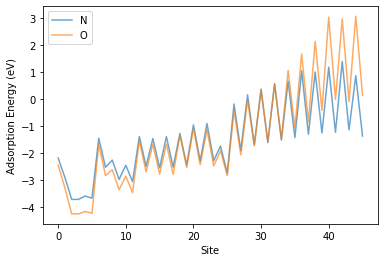

In [8]:
### Plot all adsorption energies
### To see some information on what each prediction corresponds to, examine descripList
predAdsEnNListFlat = [item for sublist in np.array(predAdsList)[:,0] for item in sublist]
predAdsEnOListFlat = [item for sublist in np.array(predAdsList)[:,1] for item in sublist]
plt.plot(range(len(predAdsEnNListFlat)),predAdsEnNListFlat,alpha=0.66)
plt.plot(range(len(predAdsEnOListFlat)),predAdsEnOListFlat,alpha=0.66)
plt.xlabel('Site')
plt.ylabel('Adsorption Energy (eV)')
plt.legend(['N','O'])
plt.show()

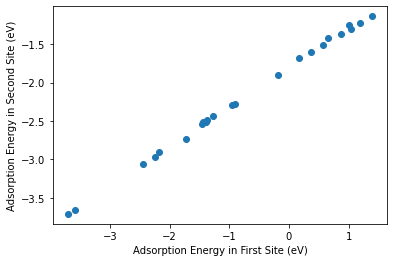

In [9]:
### Compare the two sites.
#Just N in first site:
predAdsEnNFirstSite = np.array(predAdsList)[:,0,0]
#Just N in second site:
predAdsEnNSecondSite = np.array(predAdsList)[:,0,1]
plt.scatter(predAdsEnNFirstSite,predAdsEnNSecondSite)
plt.xlabel('Adsorption Energy in First Site (eV)')
plt.ylabel('Adsorption Energy in Second Site (eV)')
plt.show()

# Example 3: visualize latent variable for example 2

In [10]:

try:
    sdCouplingList, dFillingDiffList, eCondDiffList, dFillingMultList = adsPredictor.calcFeatures(allSlabs,surfaceIndicesList)
    sdLatentList, dFillingLatentList, eCondLatentList, dFillingMultLatentList, hostConstantsList = adsPredictor.featuresToLatent(allSlabs,surfaceIndicesList,sdCouplingList,
                                                                                                                                 dFillingDiffList, eCondDiffList, dFillingMultList)
except KeyError:
        print('KeyError in predictor')
        pass
    
q=[]
for a,b,c,d,e,f in zip(sdLatentList, dFillingLatentList, eCondLatentList, dFillingMultLatentList, hostConstantsList,allSlabs):
    for i,j,k,l,m,n in zip(a,b,c,d,e,f.symbols[:9]):
        q.append({'sdLatent':i,'dFillingLatentList':j,'eCondLatentList':k,'dFillingMultLatentList':l,'hostConstantsList':m,'element':n})
    
df=pd.DataFrame(q)
 

In [11]:

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,random_state=0,perplexity=30, method='exact')
tsne_x=df[['sdLatent','dFillingLatentList','eCondLatentList','dFillingMultLatentList','hostConstantsList']]
principalComponents_tsne = tsne.fit_transform(tsne_x)
principalDf_tsne = pd.DataFrame(data = principalComponents_tsne, columns = ['tsne1','tsne2'])

from mendeleev import element

principalDf_tsne['element']=df.element
principalDf_tsne['group']= df.element.apply(lambda x: element(str(x)).group_id)
principalDf_tsne['period']= df.element.apply(lambda x: element(str(x)).period)

/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [12]:
def color_plot(df,x,y):
    groups=df.group.unique()
    fig = plt.figure()
    for i,g in enumerate(groups):
        nnew_df=df.loc[df.group==g]
        plt.scatter(nnew_df[x].values,nnew_df[y].values,s=125,label='group'+ str(g),
                    alpha=0.25,cmap='jet')#,c=[i]*len(nnew_df),vmin=0, vmax=19)
        
    plt.ylabel(y)
    plt.xlabel(x)
    plt.legend(bbox_to_anchor=(1.25, 1.04))
    plt.show
        

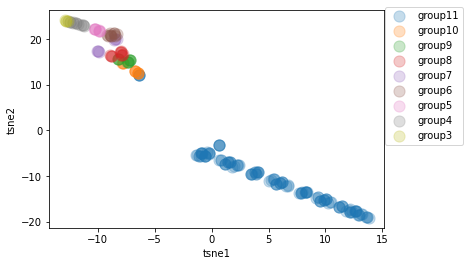

In [13]:
color_plot(principalDf_tsne,'tsne1','tsne2')